Training Policy Gradient agent...
Episode 0, Average Reward: -20535.60
Episode 100, Average Reward: -15338.04
Episode 200, Average Reward: -17334.14
Episode 300, Average Reward: -17359.27
Episode 400, Average Reward: -16135.08
Episode 500, Average Reward: -16151.65
Episode 600, Average Reward: -14687.16
Episode 700, Average Reward: -13912.01
Episode 800, Average Reward: -16585.01
Episode 900, Average Reward: -20944.22


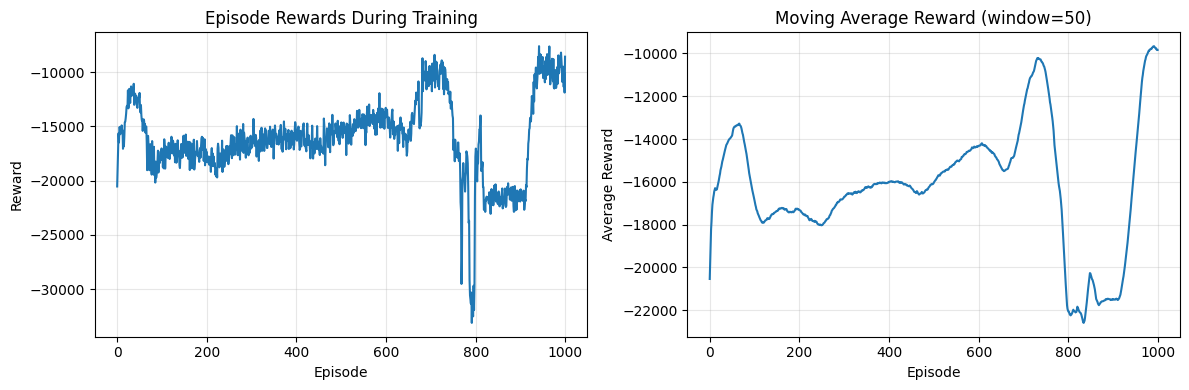


Evaluating trained agent...
Cumulative Profit - Mean: -9382.89, Std: 965.52, Max: -7072.30, Min: -11462.90


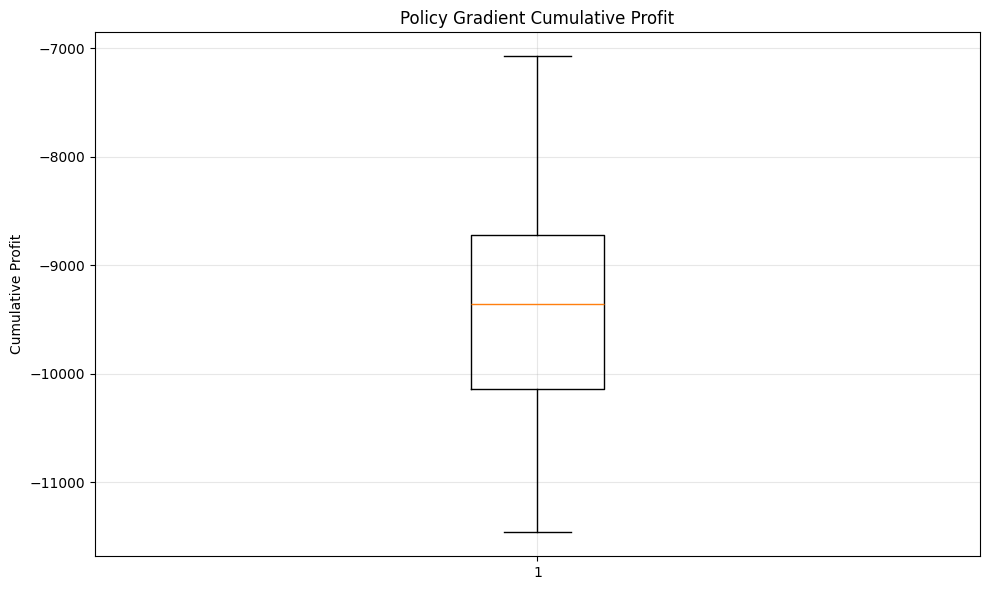

In [2]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym.spaces import Box
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import random
import collections

# Set random seeds for reproducibility
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

class State:
    """State representation for supply chain environment"""
    
    def __init__(self, product_types_num, distr_warehouses_num, T, demand_history, t=0):
        self.product_types_num = product_types_num
        self.factory_stocks = np.zeros((self.product_types_num,), dtype=np.int32)
        self.distr_warehouses_num = distr_warehouses_num
        self.distr_warehouses_stocks = np.zeros(
            (self.distr_warehouses_num, self.product_types_num), dtype=np.int32)
        self.T = T
        self.demand_history = demand_history
        self.t = t

    def to_array(self):
        from itertools import chain
        return np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten(),
            np.hstack(list(chain(*chain(*self.demand_history)))),
            [self.t]))

    def stock_levels(self):
        return np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten()))

class Action:
    """Action representation for supply chain environment"""
    
    def __init__(self, product_types_num, distr_warehouses_num):
        self.production_level = np.zeros((product_types_num,), dtype=np.int32)
        self.shipped_stocks = np.zeros(
            (distr_warehouses_num, product_types_num), dtype=np.int32)

class SupplyChainEnvironment:
    """Supply chain environment implementation"""
    
    def __init__(self):
        self.product_types_num = 2
        self.distr_warehouses_num = 2
        self.T = 25
        
        self.d_max = np.array([3, 6], np.int32)
        self.d_var = np.array([2, 1], np.int32)
        
        self.sale_prices = np.array([20, 10], np.int32)
        self.production_costs = np.array([2, 1], np.int32)
        
        self.storage_capacities = np.array([[3, 4], [6, 8], [9, 12]], np.int32)
        self.storage_costs = np.array([[6, 3], [4, 2], [2, 1]], np.float32)
        self.transportation_costs = np.array([[.1, .3], [.2, .6]], np.float32)
        
        self.penalty_costs = .5 * self.sale_prices
        
        self.reset()

    def reset(self, demand_history_len=5):
        self.demand_history = collections.deque(maxlen=demand_history_len)
        for d in range(demand_history_len):
            self.demand_history.append(np.zeros(
                (self.distr_warehouses_num, self.product_types_num), dtype=np.int32))
        self.t = 0

    def demand(self, j, i, t):
        demand = np.round(
            self.d_max[i-1]/2 +
            self.d_max[i-1]/2*np.cos(4*np.pi*(2*j*i+t)/self.T) +
            np.random.randint(0, self.d_var[i-1]+1))
        return demand

    def initial_state(self):
        return State(self.product_types_num, self.distr_warehouses_num,
                     self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(
            lambda j, i: self.demand(j+1, i+1, self.t),
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32)

        next_state = State(self.product_types_num, self.distr_warehouses_num,
                          self.T, list(self.demand_history))

        next_state.factory_stocks = np.minimum(
            np.subtract(np.add(state.factory_stocks, action.production_level),
                       np.sum(action.shipped_stocks, axis=0)),
            self.storage_capacities[0])

        for j in range(self.distr_warehouses_num):
            next_state.distr_warehouses_stocks[j] = np.minimum(
                np.subtract(np.add(state.distr_warehouses_stocks[j],
                                  action.shipped_stocks[j]), demands[j]),
                self.storage_capacities[j+1])

        # Calculate reward
        total_revenues = np.dot(self.sale_prices, np.sum(demands, axis=0))
        total_production_costs = np.dot(self.production_costs, action.production_level)
        total_transportation_costs = np.dot(
            self.transportation_costs.flatten(), action.shipped_stocks.flatten())
        total_storage_costs = np.dot(
            self.storage_costs.flatten(),
            np.maximum(next_state.stock_levels(),
                      np.zeros(((self.distr_warehouses_num+1) * self.product_types_num),
                              dtype=np.int32)))
        total_penalty_costs = -np.dot(
            self.penalty_costs,
            np.add(np.sum(np.minimum(next_state.distr_warehouses_stocks,
                                   np.zeros((self.distr_warehouses_num, self.product_types_num),
                                           dtype=np.int32)), axis=0),
                  np.minimum(next_state.factory_stocks,
                           np.zeros((self.product_types_num,), dtype=np.int32))))

        reward = (total_revenues - total_production_costs - 
                 total_transportation_costs - total_storage_costs - total_penalty_costs)

        self.demand_history.append(demands)
        self.t += 1

        return next_state, reward, self.t == self.T-1

class SupplyChain(gym.Env):
    """Gym environment wrapper"""
    
    def __init__(self):
        self.reset()
        
        # Action space bounds
        low_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num),
            dtype=np.int32)
        high_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num),
            dtype=np.int32)
        high_act[:self.supply_chain.product_types_num] = np.sum(
            self.supply_chain.storage_capacities, axis=0)
        high_act[self.supply_chain.product_types_num:] = (
            self.supply_chain.storage_capacities.flatten()[self.supply_chain.product_types_num:])
        
        self.action_space = Box(low=low_act, high=high_act, dtype=np.int32)
        
        # Observation space bounds
        low_obs = np.zeros((len(self.supply_chain.initial_state().to_array()),), dtype=np.int32)
        low_obs[:self.supply_chain.product_types_num] = (
            -np.sum(self.supply_chain.storage_capacities[1:], axis=0) * self.supply_chain.T)
        low_obs[self.supply_chain.product_types_num:
               (self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num] = (
            np.array([-(self.supply_chain.d_max+self.supply_chain.d_var) * self.supply_chain.T] * 
                    self.supply_chain.distr_warehouses_num).flatten())
        
        high_obs = np.zeros((len(self.supply_chain.initial_state().to_array()),), dtype=np.int32)
        high_obs[:(self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num] = (
            self.supply_chain.storage_capacities.flatten())
        from itertools import chain
        high_obs[(self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num:
                len(high_obs)-1] = np.array([
            self.supply_chain.d_max+self.supply_chain.d_var] * 
            len(list(chain(*self.supply_chain.demand_history)))).flatten()
        high_obs[len(high_obs)-1] = self.supply_chain.T
        
        self.observation_space = Box(low=low_obs, high=high_obs, dtype=np.int32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(
            self.supply_chain.product_types_num,
            self.supply_chain.distr_warehouses_num)
        action_obj.production_level = action[:self.supply_chain.product_types_num].astype(np.int32)
        action_obj.shipped_stocks = action[self.supply_chain.product_types_num:].reshape(
            (self.supply_chain.distr_warehouses_num, self.supply_chain.product_types_num)).astype(np.int32)

        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

# Policy Gradient Neural Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        # Policy head
        self.action_mean = nn.Linear(hidden_size, action_size)
        self.action_std = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        features = self.network(state)
        
        # Policy outputs
        action_mean = self.action_mean(features)
        action_std = F.softplus(self.action_std(features)) + 1e-5
        
        return action_mean, action_std

# Policy Gradient Agent (REINFORCE)
class PGAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99):
        self.gamma = gamma
        self.network = PolicyNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # Storage for episode
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_mean, action_std = self.network(state)
        
        dist = Normal(action_mean, action_std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action.squeeze().detach().numpy(), log_prob
    
    def store_transition(self, state, action, log_prob, reward):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
    
    def calculate_returns(self):
        returns = []
        R = 0
        
        # Calculate discounted returns
        for reward in reversed(self.rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)
        
        return torch.FloatTensor(returns)
    
    def update(self):
        if len(self.states) == 0:
            return 0
        
        # Calculate returns
        returns = self.calculate_returns()
        
        # Normalize returns for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Stack log probabilities (they already have gradients)
        log_probs = torch.stack(self.log_probs).squeeze()
        
        # Calculate policy gradient loss
        # REINFORCE: loss = -log_prob * return
        policy_loss = -(log_probs * returns).mean()
        
        # Optimization step
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # Clear episode buffer
        self.clear_buffer()
        
        return policy_loss.item()
    
    def clear_buffer(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []

def train_pg(env, episodes=1000, max_steps=25):
    """Train Policy Gradient agent on the supply chain environment"""
    state_size = len(env.reset())
    action_size = env.action_space.shape[0]
    
    agent = PGAgent(state_size, action_size)
    episode_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Get action
            action, log_prob = agent.get_action(state)
            # Clip action to valid range
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            # Take step
            next_state, reward, done, _ = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, log_prob, reward)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        # Update agent after each episode
        loss = agent.update()
        episode_rewards.append(episode_reward)
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return agent, episode_rewards

def simulate_episode(env, agent):
    """Simulate a single episode with trained agent"""
    state = env.reset()
    episode_reward = 0
    rewards = []
    
    for step in range(25):  # T = 25
        action, _ = agent.get_action(state)
        action = np.clip(action, env.action_space.low, env.action_space.high)
        
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        episode_reward += reward
        
        state = next_state
        if done:
            break
    
    return episode_reward, rewards

def calculate_cum_profit(agent, env, num_episodes=200):
    """Calculate cumulative profit over multiple episodes"""
    cumulative_profits = []
    
    for _ in range(num_episodes):
        episode_reward, _ = simulate_episode(env, agent)
        cumulative_profits.append(episode_reward)
    
    print(f"Cumulative Profit - Mean: {np.mean(cumulative_profits):.2f}, "
          f"Std: {np.std(cumulative_profits):.2f}, "
          f"Max: {np.max(cumulative_profits):.2f}, "
          f"Min: {np.min(cumulative_profits):.2f}")
    
    return cumulative_profits

def visualize_cum_profit(cumulative_profits, title="Policy Gradient Cumulative Profit"):
    """Visualize cumulative profit distribution"""
    plt.figure(figsize=(10, 6))
    plt.boxplot(cumulative_profits)
    plt.ylabel('Cumulative Profit')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_progress(episode_rewards):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))
    
    # Plot episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot moving average
    plt.subplot(1, 2, 2)
    window = 50
    moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) 
                  for i in range(len(episode_rewards))]
    plt.plot(moving_avg)
    plt.title(f'Moving Average Reward (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create environment
    env = SupplyChain()
    
    # Train Policy Gradient agent
    print("Training Policy Gradient agent...")
    agent, episode_rewards = train_pg(env, episodes=1000)
    
    # Plot training progress
    plot_training_progress(episode_rewards)
    
    # Evaluate trained agent
    print("\nEvaluating trained agent...")
    cumulative_profits = calculate_cum_profit(agent, env, num_episodes=200)
    
    # Visualize results
    visualize_cum_profit(cumulative_profits)